### Phase Retrieval with phastphase
In this example, we will do a simple demonstration recovering a (truncated) Lagurre-Gaussian Mode using phastphase. 

In [10]:
%load_ext autoreload
%autoreload 2


import sys, os
import scipy
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), '../../fastphase'))
import phastphase


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
if torch.cuda.is_available():
    tensor_device = torch.device('cuda')
else:
    tensor_device = torch.device('cpu')

We start by Establishing the coordinate system, and creating the Gauss-Hermite (3,3) mode, with an added roating phase to make the problem more interesting. 

In [12]:
#Set up number of sample points, and oversampling for the DFT
n_pts = 2**8
oversample_factor = 2
herm_gauss_ord = 3


#Define the coordinate system, we will truncate the Hermite-Gauss modes
x_bound = 1.4
y_bound = 1.4
x = np.linspace(-x_bound,x_bound, n_pts)
y = np.linspace(-y_bound,y_bound, n_pts)
x,y = np.meshgrid(x,y)
r = np.sqrt((x+x_bound)**2+(y+y_bound)**2)


#Create the Hermite-Gauss modes, with a rotating phase added
herm_gauss_beam = special.eval_hermite(herm_gauss_ord,np.sqrt(2)*x)*special.eval_hermite(herm_gauss_ord,np.sqrt(2)*y)*np.exp(-(x**2 + y**2))

#Add a rotating phase to make it more interesting
herm_gauss_beam = herm_gauss_beam*np.exp(3j*np.arctan2(x,y))





Let's look at the magnitude and phase profiles.

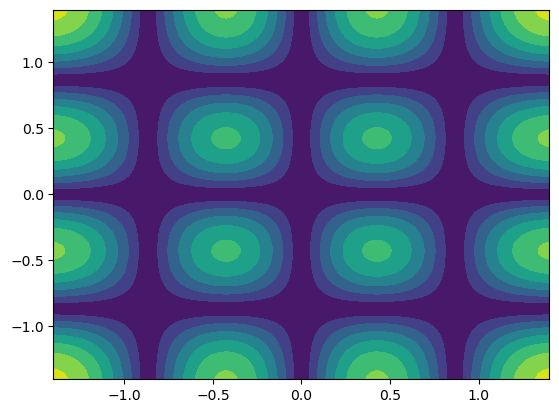

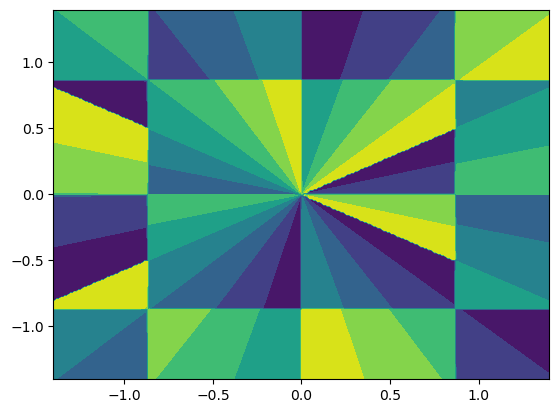

In [13]:
plt.figure()
plt.contourf(x,y,np.abs(herm_gauss_beam))
plt.figure()
plt.contourf(x,y,np.angle(herm_gauss_beam))

Without near-field information, phastphase only (verifiably) works on Schwarz objects. To make this Hermite-Gauss beam Schwarz, we will apply a moderate exponential decrease along each axis.

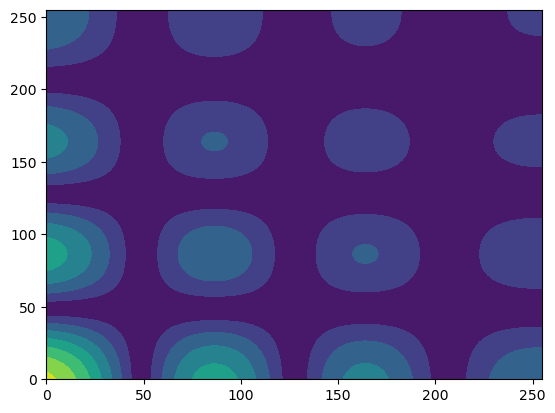

In [14]:
beam_1 = herm_gauss_beam*np.exp(-(x+x_bound)/3)*np.exp(-(y+y_bound)/3)
plt.contourf(np.abs(beam_1))

We then move the data over to torch, and find the far_field intensity pattern

In [15]:
near_field = torch.tensor(beam_1,device=tensor_device)
near_field /= torch.exp(1j*torch.angle(near_field[0,0]))
far_field = torch.square(torch.abs(torch.fft.fftn(near_field,(oversample_factor*n_pts, oversample_factor*n_pts), norm='ortho')))

We are now ready to retrieve the near_field using phastphase.retrieve. The input will be the far_field intensities, along with the support. Printing the relative squared error of the retrieved near field compared to the ground truth reveals a succseful recovery!

In [16]:

reconstruction = phastphase.retrieve(far_field,[n_pts,n_pts], reference_point = [0,0])
reconstruction /= torch.exp(1j*torch.angle(reconstruction[0,0]))
print(f'Reconstruction Relative Squared Error is {(torch.linalg.vector_norm(reconstruction-near_field)/torch.linalg.vector_norm(near_field)).item():.0e}')


Reconstruction Relative Squared Error is 6e-12


Let's try an object with a much weaker exponential decrease, mathematically "less Schwarz"

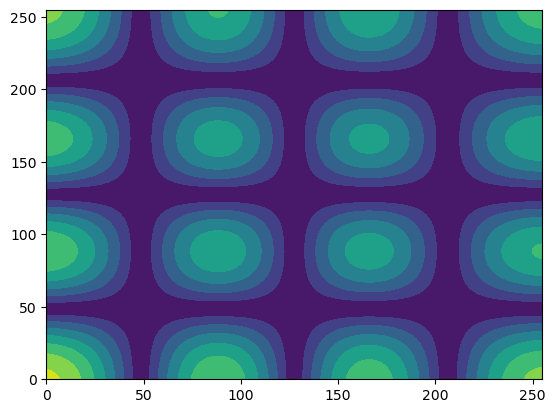

In [17]:
beam_2 = herm_gauss_beam*np.exp(-(x+x_bound)/20)*np.exp(-(y+y_bound)/20)
plt.contourf(np.abs(beam_2))

vanilla phastphase will have some trouble with this object, but we can help by giving it known near_field amplitudes:

In [18]:

near_field = torch.tensor(beam_2,device=tensor_device)
near_field /= torch.exp(1j*torch.angle(near_field[0,0]))
far_field = torch.square(torch.abs(torch.fft.fftn(near_field,(oversample_factor*n_pts, oversample_factor*n_pts), norm='ortho')))
reconstruction = phastphase.retrieve(far_field,[n_pts,n_pts], reference_point = [0,0], known_nearfield_amp = torch.abs(near_field))
reconstruction /= torch.exp(1j*torch.angle(reconstruction[0,0]))
print(f'Reconstruction Relative Squared Error is {(torch.linalg.vector_norm(reconstruction-near_field)/torch.linalg.vector_norm(near_field)).item():.0e}')



Reconstruction Relative Squared Error is 5e-12
